# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [1]:
import typing
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    heading: float
    velocity: npt.NDArray[np.float64]


Observation: typing.TypeAlias = tuple[State, State]
Action: typing.TypeAlias = tuple[float, float]

In [78]:
import metadrive
from metadrive import MetaDriveEnv
import gymnasium as gym
import typing

import torch
import torch.nn as nn
import torch.nn.functional as F

def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_metadrive_state(env: MetaDriveEnv) -> State:
    return State(heading=env.vehicle.heading_theta, velocity=env.vehicle.velocity[:2])

def next_state(env: MetaDriveEnv, s: State, a: Action) -> State:
    """
    runs the policy and returns the total reward
    """
    # reset
    env.reset()
    env.vehicle.set_position(env.vehicle.position, height=0.49)

    # allow car to settle
    for _ in range(5):
        env.step([0,0])

    # set the initial state
    env.vehicle.set_velocity(s.velocity)
    env.vehicle.set_heading_theta(s.heading)
    
    # run the simulator
    env.step(a)

    # get the new state
    s_prime = get_metadrive_state(env)

    # allow car to settle (if rendering)
    if env.config.use_render:
        for _ in range(10):
            env.step([0,0])

    return s_prime

def gen_scenario() -> tuple[State, Action]:
    """
    Generates a random scenario
    """
    # generate a random state
    velocity = np.random.multivariate_normal([0, 0], np.eye(2) * 100)
    heading = normalize_angle(np.arctan2(velocity[1], velocity[0]) + np.random.normal(0, np.pi/4))

    s = State(heading=heading, velocity=velocity)

    # generate a random action
    steer = np.random.uniform(-1, 1)
    throttle = np.random.uniform(-1, 1)
    a = (steer, throttle)

    return s, a

def state_batch_to_tensor(states: list[State], device: torch.device) -> torch.Tensor:
    """
    Reshape the state from State to a tensor of shape (batch_size, 3)
    """

    return torch.tensor(np.stack([
        [st.velocity[0], st.velocity[1], st.heading] for st in states
    ]), dtype=torch.float32, device=device)

def action_batch_to_tensor(actions: list[Action], device: torch.device) -> torch.Tensor:
    """
    Reshape the action from Action to a tensor of shape (batch_size, 2)
    """
    return torch.tensor(np.stack(actions), dtype=torch.float32, device=device)

def obs_batch_to_tensor(obs: list[Observation], device: torch.device) -> torch.Tensor:
    """
    Reshape the observation from tuple[State, State] to a tensor of shape (batch_size, 3, 2)
    """

    observations = []

    for st0, st1 in obs:
        observations.append(np.array([
            [st0.velocity[0], st1.velocity[0]], 
            [st0.velocity[1], st1.velocity[1]],
            [st0.heading, st1.heading]
        ]))

    return torch.tensor(np.stack(observations), dtype=torch.float32, device=device)

This task may take a few minutes to run the first time.

In [187]:
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

MAX_WORKERS = 16
DATASET_SIZE = 10000

def generate_data(n_scenarios: int) -> list[tuple[State, Action, State]]:
    env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})
    dataset: list[tuple[State, Action, State]] = []
    for _ in range(n_scenarios):
        s0, a = gen_scenario()
        s1 = next_state(env, s0, a)
        dataset.append((s0, a, s1))
    env.close()
    return dataset

mm_train_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(DATASET_SIZE, MAX_WORKERS)
    for batch in executor.map(generate_data, [*[batch_size]*MAX_WORKERS, leftover_size]):
        mm_train_data.extend(batch)

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
(:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task:task(warning): (warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskMa

In [177]:
mm_validation_data = generate_data(1000)

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


In [178]:
print("training data:", len(mm_train_data))
print("validation data:", len(mm_validation_data))

NameError: name 'mm_train_data' is not defined

In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# create a model that attempts to predict the next state given the current state and the action: (throttle and steering)
# each state contains: velocity_x, velocity_y, and heading
class MetadriveModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3) + (batch_size, 2) = (batch_size, 5)
        # output shape: (batch_size, 3)
        self.fc1 = nn.Linear(5, 512) # Bx5 -> Bx512
        self.fc2 = nn.Linear(512, 512) # Bx512 -> Bx256
        self.fc3 = nn.Linear(512, 3) # Bx256 -> Bx3
    
    def forward(self, states: torch.Tensor, actions: torch.Tensor):
        x = torch.cat([states, actions], dim=1) # Bx5
        x = F.relu(self.fc1(x)) # Bx512
        x = F.relu(self.fc2(x)) # Bx512
        x = self.fc3(x) # Bx3
        return x

def metadrive_model_train_batch(
    mm: MetadriveModel,
    mm_optimizer: torch.optim.Optimizer,
    s0_batch: list[State],
    a_batch: list[Action],
    s1_batch: list[State],
) -> float: 
    device = deviceof(mm)

    s0_tensor = state_batch_to_tensor(s0_batch, device) 
    a_tensor = action_batch_to_tensor(a_batch, device)
    s1_tensor = state_batch_to_tensor(s1_batch, device)

    mm_optimizer.zero_grad()
    s1_pred_tensor = mm(s0_tensor, a_tensor)
    loss = F.mse_loss(s1_pred_tensor, s1_tensor)
    loss.backward()
    mm_optimizer.step()
    return float(loss.item())



In [ ]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [191]:
import itertools
# make sure we don't run out of data
mm_train_iter = itertools.cycle(mm_train_data)

mm = MetadriveModel().to(device)

mm_optimizer = torch.optim.Adam(mm.parameters())

mm_step = 0
mm_losses = []

In [193]:
set_lr(mm_optimizer, 1e-5)
METADRIVE_MODEL_TRAIN_EPOCHS = 4000
METADRIVE_MODEL_TRAIN_BATCH_SIZE = 2048

while mm_step < METADRIVE_MODEL_TRAIN_EPOCHS:
    # take up to n from the data buffer
    data_batch = [next(mm_train_iter) for _ in range(METADRIVE_MODEL_TRAIN_BATCH_SIZE)]
    # unpack the batch
    s0_batch = [s0 for s0, _, _ in data_batch]
    a_batch = [a for _, a, _ in data_batch]
    s1_batch = [s1 for _, _, s1 in data_batch]
    loss = metadrive_model_train_batch(mm, mm_optimizer, s0_batch, a_batch, s1_batch)
    mm_losses.append(loss)
    mm_step += 1
    print(f"Step: {mm_step}, Loss: {loss:.3f}")

Step: 1, Loss: 63.981
Step: 2, Loss: 64.212
Step: 3, Loss: 63.873
Step: 4, Loss: 64.268
Step: 5, Loss: 61.975
Step: 6, Loss: 63.006
Step: 7, Loss: 62.846
Step: 8, Loss: 62.234
Step: 9, Loss: 61.594
Step: 10, Loss: 61.173
Step: 11, Loss: 61.655
Step: 12, Loss: 60.016
Step: 13, Loss: 60.299
Step: 14, Loss: 60.424
Step: 15, Loss: 59.961
Step: 16, Loss: 58.798
Step: 17, Loss: 59.180
Step: 18, Loss: 58.973
Step: 19, Loss: 58.128
Step: 20, Loss: 57.874
Step: 21, Loss: 57.767
Step: 22, Loss: 57.869
Step: 23, Loss: 56.185
Step: 24, Loss: 56.960
Step: 25, Loss: 56.608
Step: 26, Loss: 56.340
Step: 27, Loss: 55.405
Step: 28, Loss: 55.216
Step: 29, Loss: 55.582
Step: 30, Loss: 54.201
Step: 31, Loss: 54.504
Step: 32, Loss: 54.266
Step: 33, Loss: 54.140
Step: 34, Loss: 52.700
Step: 35, Loss: 53.540
Step: 36, Loss: 52.912
Step: 37, Loss: 52.653
Step: 38, Loss: 52.160
Step: 39, Loss: 51.739
Step: 40, Loss: 52.050
Step: 41, Loss: 50.691
Step: 42, Loss: 50.995
Step: 43, Loss: 51.039
Step: 44, Loss: 50.6

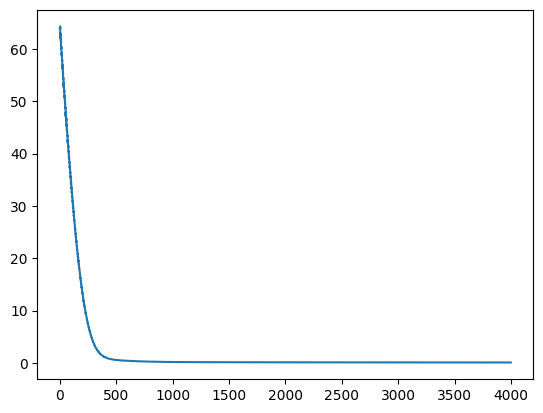

In [194]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(mm_losses))), mm_losses, label='MM')
plt.show()

In [197]:
s0_batch = [s0 for s0, _, _ in mm_validation_data]
s1_batch = [s1 for _, _, s1 in mm_validation_data]
a_batch = [a for _, a, _ in mm_validation_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2]

print("validation loss", loss.mean().item())

validation loss 0.09680616110563278


In [198]:
s0_batch = [s0 for s0, _, _ in mm_train_data]
s1_batch = [s1 for _, _, s1 in mm_train_data]
a_batch = [a for _, a, _ in mm_train_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2]

print("training loss", loss.mean().item())



training loss 0.07631634920835495


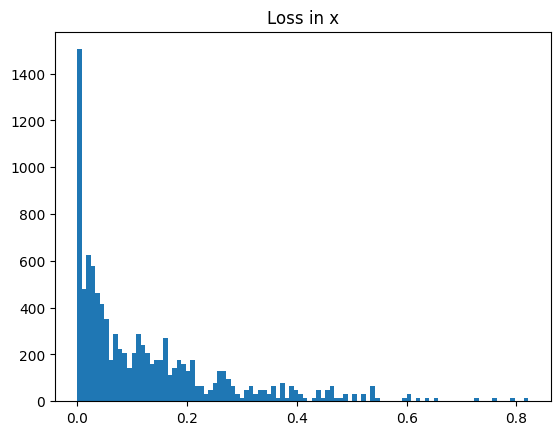

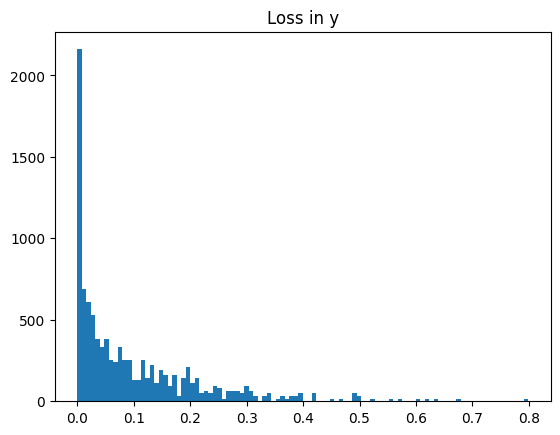

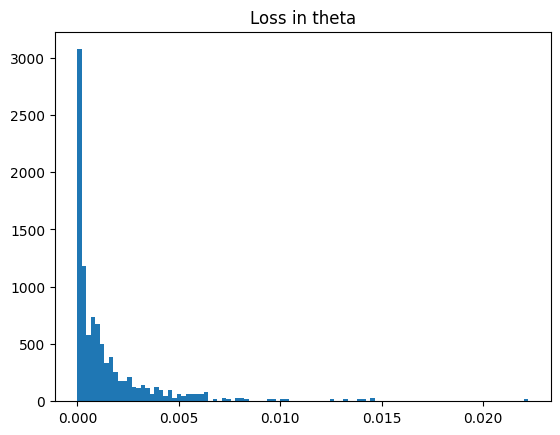

In [199]:
plt.hist(loss_x.cpu().detach().numpy(), bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y.cpu().detach().numpy(), bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta.cpu().detach().numpy(), bins=100)
plt.title('Loss in theta')
plt.show()


Now that we have trained a neural network model of Metadrive through which we can backprop, training the IDM is easy.

In [175]:
from protos import scenario_pb2
from tensorflow.data import TFRecordDataset
import tqdm
import os

def getFiles(path: str) -> list[str]:
    path = os.path.expanduser(path)
    files = [os.path.join(path, f) for f in os.listdir(path)]
    return [f for f in files if os.path.isfile(f)]


files = getFiles('~/data/waymo/')

def parse_scenario(scenario: scenario_pb2.Scenario) -> list[State]:
    states = []
    for s in scenario.tracks[scenario.sdc_track_index].states:
        if s.valid:
            states.append(State(s.heading, np.array([s.velocity_x, s.velocity_y], dtype=np.float32)))
    return states


h: list[list[State]] = []

for file_path in tqdm.tqdm(files):
    for data in TFRecordDataset(file_path, compression_type="").as_numpy_iterator():
        scenario = scenario_pb2.Scenario()
        scenario.ParseFromString(data)
        h.append(parse_scenario(scenario))


2023-08-11 00:16:17.130599: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 00:16:18.331230: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  0%|          | 0/100 [00:00<?, ?it/s]2023-08-11 00:16:19.189922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-11 00:16:19.209057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at l

In [200]:
idm_train_data: list[Observation] = []
for states in h:
    for i in range(len(states)-1):
        idm_train_data.append((states[i], states[i+1]))

print("train data:", len(idm_train_data))

train data: 42268


In [ ]:
import random
random.shuffle(idm_train_data)

In [205]:
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(3, 512, 2) # Bx3x2 -> Bx512x1
        self.fc1 = nn.Linear(512, 256) # Bx512 -> Bx256
        self.fc2 = nn.Linear(256, 256) # Bx256 -> Bx256
        self.fc3 = nn.Linear(256, 2) # Bx256 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx3x2 -> Bx512x1
        x = torch.flatten(x, 1) # Bx512x1 -> Bx512
        x = F.relu(self.fc1(x)) # Bx512 -> Bx256
        x = F.relu(self.fc2(x)) # Bx256 -> Bx256
        x = self.fc3(x) # Bx256 -> Bx2
        return x

def idm_train_batch(
        mm: MetadriveModel,
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_batch: list[Observation],
) -> float:
    device = deviceof(mm)

    assert deviceof(idm) == device

    obs_tensor = obs_batch_to_tensor(obs_batch, device)
    s0_batch = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
    s1_batch = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)
    pred_s1 = mm(s0_batch, pred_action)

    loss = F.mse_loss(pred_s1, s1_batch)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [226]:
idm_train_iter = itertools.cycle(idm_train_data)

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.Adam(idm.parameters())

idm_step = 0
idm_losses = []

In [228]:
set_lr(idm_optimizer, 1e-5)
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 1000
INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE = len(idm_train_data)

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    obs_batch = [next(idm_train_iter) for _ in range(INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE)]
    loss = idm_train_batch(
        mm,
        idm,
        idm_optimizer,
        obs_batch,
    )
    idm_losses.append(loss)
    idm_step += 1
    print(f"Step: {idm_step}, Loss: {loss:.3f}")

Step: 56, Loss: 0.059
Step: 57, Loss: 0.059
Step: 58, Loss: 0.059
Step: 59, Loss: 0.058
Step: 60, Loss: 0.058
Step: 61, Loss: 0.058
Step: 62, Loss: 0.057
Step: 63, Loss: 0.057
Step: 64, Loss: 0.057
Step: 65, Loss: 0.057
Step: 66, Loss: 0.056
Step: 67, Loss: 0.056
Step: 68, Loss: 0.056
Step: 69, Loss: 0.056
Step: 70, Loss: 0.055
Step: 71, Loss: 0.055
Step: 72, Loss: 0.055
Step: 73, Loss: 0.055
Step: 74, Loss: 0.055
Step: 75, Loss: 0.054
Step: 76, Loss: 0.054
Step: 77, Loss: 0.054
Step: 78, Loss: 0.054
Step: 79, Loss: 0.053
Step: 80, Loss: 0.053
Step: 81, Loss: 0.053
Step: 82, Loss: 0.053
Step: 83, Loss: 0.053
Step: 84, Loss: 0.052
Step: 85, Loss: 0.052
Step: 86, Loss: 0.052
Step: 87, Loss: 0.052
Step: 88, Loss: 0.052
Step: 89, Loss: 0.052
Step: 90, Loss: 0.051
Step: 91, Loss: 0.051
Step: 92, Loss: 0.051
Step: 93, Loss: 0.051
Step: 94, Loss: 0.051
Step: 95, Loss: 0.051
Step: 96, Loss: 0.050
Step: 97, Loss: 0.050
Step: 98, Loss: 0.050
Step: 99, Loss: 0.050
Step: 100, Loss: 0.050
Step: 101

KeyboardInterrupt: 

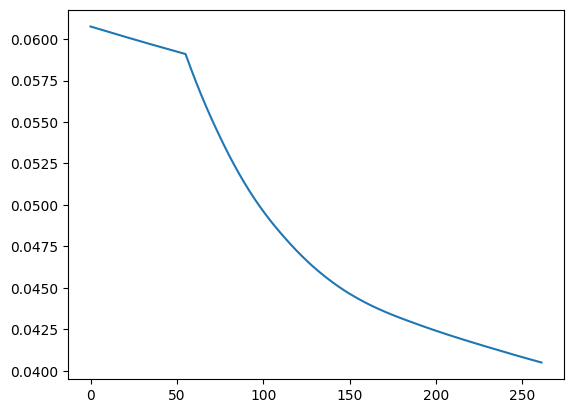

In [229]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

Let's try visualizing our IDM by having it follow a track from start to finish.

In [231]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return steering.item(), throttle.item()


In [235]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": True})

In [238]:
scenario = h[5]
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        action = IDMPolicy(idm)((st0, st1))
        print(action)
        env.step(action)

        

(0.23398125171661377, 2.235740900039673)
(0.22450466454029083, 2.2197630405426025)
(0.21545925736427307, 2.19934344291687)
(0.20586682856082916, 2.181835174560547)
(0.1960819810628891, 2.163665533065796)
(0.18639440834522247, 2.1444876194000244)
(0.17687784135341644, 2.12400221824646)
(0.16806603968143463, 2.1021616458892822)
(0.15922504663467407, 2.0799710750579834)
(0.15046285092830658, 2.0585060119628906)
(0.14027027785778046, 2.0367465019226074)
(0.13081146776676178, 2.01294207572937)
(0.12264731526374817, 1.9907890558242798)
(0.11516231298446655, 1.9738672971725464)
(0.10618942975997925, 1.9583805799484253)
(0.0952807366847992, 1.9372316598892212)
(0.08570270240306854, 1.910286545753479)
(0.07883188128471375, 1.8855081796646118)
(0.07203981280326843, 1.8680500984191895)
(0.06312429904937744, 1.853269100189209)
(0.051841944456100464, 1.8336271047592163)
(0.04071490466594696, 1.8072737455368042)
(0.03375151753425598, 1.7818516492843628)
(0.027531251311302185, 1.7625783681869507)
(0.

In [239]:
env.close()